In [15]:
# Imports
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [16]:
# Setting Directory to the LCR Data Set.
# Then, sets up a Data Frame of the unfiltered data.
# Finally, prints out the unfiltered data as a table.
os.getcwd()
os.chdir('/Users/glatiolait/Documents/LCR/LCR_files+scripts')
table = "new_db_Feb2023.csv"
opened = open(table,"r")
readed = pd.read_csv(table, sep=",")
tablelist = list(csv.reader(readed))
data_array = np.array(readed)
df = pd.DataFrame(data_array)
df

,0,1,2,3,4,5,6,7,8,9
0,0,4FGL J0001.2-0747,daily,239587201,239846401,0.0,0.0,2.18,0.0,2.44
1,1,4FGL J0001.5+2113,daily,239587201,239846401,NaN,NaN,NaN,0.0,0.52
2,2,4FGL J0003.3-1928,daily,239587201,239846401,NaN,NaN,NaN,102.0,-0.0
3,3,4FGL J0004.3+4614,daily,239587201,239846401,NaN,NaN,NaN,102.0,-0.0
4,4,4FGL J0004.4-4737,daily,239587201,239846401,0.0,0.0,2.97,0.0,8.93
...,...,...,...,...,...,...,...,...,...,...
4132745,4132745,4FGL J2358.0-4601,weekly,698630401,699235201,NaN,NaN,NaN,NaN,NaN
4132746,4132746,4FGL J2358.3-1021,weekly,698630401,699235201,NaN,NaN,NaN,NaN,NaN
4132747,4132747,4FGL J2358.3+3830,weekly,698630401,699235201,NaN,NaN,NaN,NaN,NaN
4132748,4132748,4FGL J2359.0+3922,weekly,698630401,699235201,NaN,NaN,NaN,NaN,NaN


In [51]:
# Prompts the User for a selection of Cadence values. 
# I accounted for possible misspellings regarding capitalization.
# If the cadence value inputted is incorrect, then an error is displayed.
# The function then takes the inputted cadence string, and filters the DataFrame table with that.

cadence = input("Input Cadence Selection. (daily, weekly, or monthly) Case Sensitive.")
if cadence not in ['daily', 'Daily', 'weekly', 'Weekly', 'monthly', 'Monthly']:
    print("Error. Invalid option")

# This section takes the user input for cadence, and then outputs a data set for a random source within that cadence value.
# The randomsource variable takes a random name from the list, so some sources may be weighted far more heavily than others.
# I am not sure if the randomness is necessary, but it allowed an easy way to test multiple graphs.
# I have also included a default source name to check against consistently.

randomsource = np.random.choice(data_array[:,1])
randomsource = '4FGL J0001.2-0747'


# Prints out which source was randomly picked. Not necessary for using the default option.
print(randomsource)

# Filters the catalogue to only randomsource, cadence, sigma values larger than 4, and photon flux values greater than their error margins.
sortedsources = np.where((data_array[:,1] == randomsource) & (data_array[:,2]==cadence) & (data_array[:,-1] >= 4) & (data_array[:,6] < data_array[:,5]))

# Displays the dataframe to ensure everything is working as intended. Will omit in the future.
pd.DataFrame(data_array[sortedsources])

4FGL J0001.2-0747


,0,1,2,3,4,5,6,7,8,9
0,22875,4FGL J0001.2-0747,daily,242179201,242438401,0.0,0.0,3.11,0.0,11.88
1,42700,4FGL J0001.2-0747,daily,244512001,244771201,0.0,0.0,1.52,0.0,22.58
2,70150,4FGL J0001.2-0747,daily,247363201,247622401,0.0,0.0,0.89,0.0,10.63
3,99125,4FGL J0001.2-0747,daily,250732801,250992001,0.0,0.0,3.81,102.0,4.2
4,126575,4FGL J0001.2-0747,daily,253843201,254102401,0.0,0.0,4.57,102.0,4.01
...,...,...,...,...,...,...,...,...,...,...
139,3702700,4FGL J0001.2-0747,daily,651456001,651715201,0.0,0.0,3.29,0.0,6.63
140,3829275,4FGL J0001.2-0747,daily,665452801,665712001,0.0,0.0,3.43,0.0,4.84
141,3847575,4FGL J0001.2-0747,daily,667526401,667785601,0.0,0.0,2.01,0.0,4.69
142,3961950,4FGL J0001.2-0747,daily,680227201,680486401,0.0,0.0,1.22,0.0,14.92


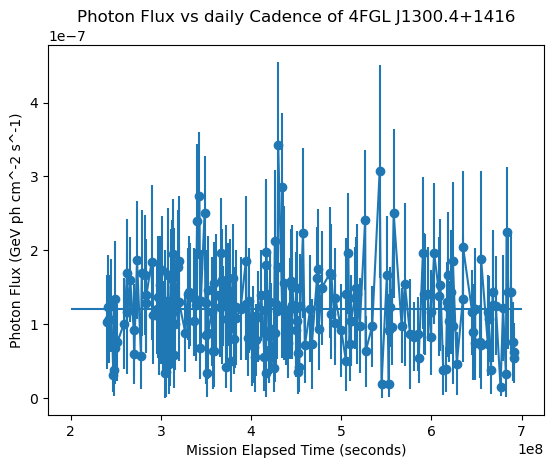

In [44]:
# This block of code is where a majority of the plots will go.

GraphTest = (data_array[sortedsources])
Plot = pd.DataFrame(GraphTest)
ysize = Plot.size
x = pd.DataFrame(GraphTest[:,3]/(60*60*24*365))

# The title displays the name of the graph, with references that will vary the cadence and name of the source.
plt.title("Photon Flux vs " +GraphTest[0,2]+ " Cadence of "+GraphTest[0,1])

# The x-axis displays the time elapsed in seconds. I would like to convert this to be a range of years.
plt.xlabel("Mission Elapsed Time (seconds)")

# The y-axis displays the Photon Flux. I don't believe the numerical labels are correct, but the shape of the graph appears to be correct.
plt.ylabel("Photon Flux (GeV ph cm^-2 s^-1)")

# This is the actual function that plots the data. At the moment, it plots column 3 (Time) vs column 5 (Photon Flux)
#Graph = plt.plot(Plot[3],Plot[5])
plt.errorbar(Plot[3],Plot[5],yerr=Plot[6],fmt = 'o-')
plt.hlines(np.mean(GraphTest[:,5]),2e8,7e8)

In [54]:
# This is the setup of the main loop to analyze one source.
# This loop can be modified to display either the factors of average flux at any time bin, or can be used to display a binary array
# Of "If above average flux, value is 1. If below, value is 0."
# At the moment, the loop will display an array of the factors at each time bin.
base = np.zeros(len(GraphTest))
averageflux = np.mean(GraphTest[:,5])
factors = GraphTest[:,5]/averageflux
emptyarray = [0]
j = 0
k = 0
emptyarray=[0]
while j < len(base):
    if (factors[j] < 1) and (factors[j-1]) > 0:
        emptyarray.append(0)
        k+=1
    elif factors[j] > 0:
        emptyarray[k] = factors[j]
    j+=1

print(emptyarray)

[0, 1.031333034012203, 0, 1.0396502358993984, 0, 0, 0, 0, 1.1145050528841551, 0, 1.4139243208231818, 1.33075230195123, 0, 1.5553167529054999, 1.5303651472439144, 0, 1.1394566585457406, 1.2725318887408636, 1.4388759264847673, 0, 0, 1.0978706491097645, 1.3889727151615963, 0, 1.3473867057256201, 1.6218543680030615, 1.247580283079278, 1.0812362453353743, 1.1228222547713502, 2.2789133170914813, 2.079300471798797, 1.0729190434481792, 1.2226286774176924, 0, 0, 1.2974834944024491, 1.289166292515254, 0, 1.1311394566585453, 1.205994273643302, 1.3473867057256201, 0, 1.023015832125008, 1.064601841560984, 1.0978706491097645, 0, 0, 0, 0, 0, 1.1560910623201308, 0, 0, 0, 1.646805973664647, 0, 1.0812362453353743, 0, 1.7715640019725747, 1.0562846396737888, 1.2974834944024491, 0, 1.247580283079278, 1.2392630811920828, 0, 0, 0, 1.8630532227317218, 1.0063814283506176, 1.4555103302591577, 1.4139243208231818, 1.3889727151615963, 1.1311394566585453, 0, 1.6301715698902568, 0, 0, 1.1727254660945214, 2.004445654

In [55]:
# This is just displaying all values of the source that are above a factor of 1.
factors[factors>1]

array([1.031333034012203, 1.0396502358993984, 1.1145050528841551,
       1.4139243208231818, 1.33075230195123, 1.5553167529054999,
       1.4056071189359864, 1.3889727151615963, 1.0729190434481792,
       1.1560910623201308, 1.5303651472439144, 1.1394566585457406,
       1.2725318887408636, 1.4388759264847673, 1.0978706491097645,
       1.0562846396737888, 1.3889727151615963, 1.3473867057256201,
       1.339069503838425, 1.4139243208231818, 1.6218543680030615,
       1.247580283079278, 1.4804619359207434, 1.5469995510183048,
       1.0812362453353743, 1.1727254660945214, 1.1893598698689116,
       1.1644082642073263, 1.1228222547713502, 1.0479674377865935,
       1.9961284529268446, 2.2789133170914813, 1.0978706491097645,
       2.079300471798797, 1.0729190434481792, 1.2226286774176924,
       1.2974834944024491, 1.1560910623201308, 1.1560910623201308,
       1.023015832125008, 1.6301715698902568, 1.0479674377865935,
       1.10618785099696, 1.33075230195123, 1.0396502358993984,
      